# **Similarity between two images**

## **Import**

In [7]:
!pip install keras
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install sklearn

  Using cached sklearn-0.0-py2.py3-none-any.whl


In [18]:
# Import libraries and modules
from keras.datasets import cifar100
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

## **Dataset**

### Load Dataset

In [42]:
# load dataset

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Split x_train in half and make x_validation
x_validation = x_test[0:5000]
x_test = x_test[5000:]
y_validation = y_test[0:5000]
y_test = y_test[5000:]

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (5000, 32, 32, 3)
assert x_validation.shape == (5000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_validation.shape == (5000, 1)
assert y_test.shape == (5000, 1)

print('x_train shape:', x_train.shape)
print('x_validation shape:', x_validation.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_validation shape:', y_validation.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
x_validation shape: (5000, 32, 32, 3)
x_test shape: (5000, 32, 32, 3)
y_train shape: (50000, 1)
y_validation shape: (5000, 1)
y_test shape: (5000, 1)


In [43]:
classes = {
    0: "apple",
    1: "aquarium_fish",
    2: "baby",
    3: "bear",
    4: "beaver",
    5: "bed",
    6: "bee",
    7: "beetle",
    8: "bicycle",
    9: "bottle",
    10: "bowl",
    11: "boy",
    12: "bridge",
    13: "bus",
    14: "butterfly",
    15: "camel",
    16: "can",
    17: "castle",
    18: "caterpillar",
    19: "cattle",
    20: "chair",
    21: "chimpanzee",
    22: "clock",
    23: "cloud",
    24: "cockroach",
    25: "couch",
    26: "cra",
    27: "crocodile",
    28: "cup",
    29: "dinosaur",
    30: "dolphin",
    31: "elephant",
    32: "flatfish",
    33: "forest",
    34: "fox",
    35: "girl",
    36: "hamster",
    37: "house",
    38: "kangaroo",
    39: "keyboard",
    40: "lamp",
    41: "lawn_mower",
    42: "leopard",
    43: "lion",
    44: "lizard",
    45: "lobster",
    46: "man",
    47: "maple_tree",
    48: "motorcycle",
    49: "mountain",
    50: "mouse",
    51: "mushroom",
    52: "oak_tree",
    53: "orange",
    54: "orchid",
    55: "otter",
    56: "palm_tree",
    57: "pear",
    58: "pickup_truck",
    59: "pine_tree",
    60: "plain",
    61: "plate",
    62: "poppy",
    63: "porcupine",
    64: "possum",
    65: "rabbit",
    66: "raccoon",
    67: "ray",
    68: "road",
    69: "rocket",
    70: "rose",
    71: "sea",
    72: "seal",
    73: "shark",
    74: "shrew",
    75: "skunk",
    76: "skyscraper",
    77: "snail",
    78: "snake",
    79: "spider",
    80: "squirrel",
    81: "streetcar",
    82: "sunflower",
    83: "sweet_pepper",
    84: "table",
    85: "tank",
    86: "telephone",
    87: "television",
    88: "tiger",
    89: "tractor",
    90: "train",
    91: "trout",
    92: "tulip",
    93: "turtle",
    94: "wardrobe",
    95: "whale",
    96: "willow_tree",
    97: "wolf",
    98: "woman",
    99: "worm"
}

In [47]:
data_to_classes = {}

for i, x in enumerate(y_train):

    element = int(x[0])
    
    try:   
        data_to_classes[element].append(x_train[i])
    except:
        data_to_classes[element] = []
        data_to_classes[element].append(x_train[i])

In [49]:
print(data_to_classes[1])

[array([[[ 43,  49,  46],
        [ 32,  40,  34],
        [ 87,  89,  47],
        ...,
        [ 74,  84,  48],
        [ 43,  51,  30],
        [ 39,  45,  33]],

       [[ 44,  47,  51],
        [ 38,  42,  42],
        [ 59,  61,  32],
        ...,
        [ 66,  74,  47],
        [ 40,  47,  31],
        [ 40,  46,  34]],

       [[ 45,  45,  50],
        [ 43,  43,  44],
        [ 44,  47,  30],
        ...,
        [ 51,  58,  40],
        [ 40,  46,  34],
        [ 43,  49,  37]],

       ...,

       [[ 51,  50,  31],
        [ 56,  51,  33],
        [ 72,  64,  45],
        ...,
        [109,  94,  43],
        [160, 154,  90],
        [125, 120,  62]],

       [[ 80,  77,  45],
        [ 68,  62,  33],
        [ 78,  69,  42],
        ...,
        [101,  92,  54],
        [ 82,  79,  36],
        [ 75,  76,  32]],

       [[109, 102,  57],
        [ 92,  84,  47],
        [108,  99,  67],
        ...,
        [ 93,  88,  60],
        [ 55,  55,  29],
        [ 63,  67,  37]

C:\Users\Svendpai\AppData\Local\Temp/ipykernel_4380/3057073278.py:17: DeprecationWarning: This function is deprecated. Please call randint(0, 499 + 1) instead
  data_to_classes[i][np.random.random_integers(0, data_to_classes[i].__len__() - 1)]])
C:\Users\Svendpai\AppData\Local\Temp/ipykernel_4380/3057073278.py:22: DeprecationWarning: This function is deprecated. Please call randint(0, 99 + 1) instead
  data_to_classes[np.random.random_integers(0, classes.__len__() - 1)][np.random.random_integers(0, data_to_classes[i].__len__() - 1)]])
C:\Users\Svendpai\AppData\Local\Temp/ipykernel_4380/3057073278.py:22: DeprecationWarning: This function is deprecated. Please call randint(0, 499 + 1) instead
  data_to_classes[np.random.random_integers(0, classes.__len__() - 1)][np.random.random_integers(0, data_to_classes[i].__len__() - 1)]])


1


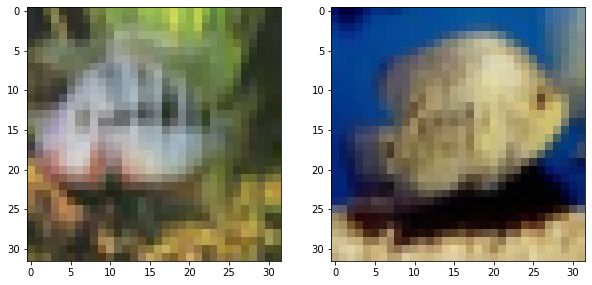

In [76]:
# make new dataset with pairs of images

    # /*
    # //data_set: [img1, img2, label]

dataset = []
labels = []

import math

amount_of_pairs = 50

for i in range(classes.__len__()):
    for j in range(amount_of_pairs):
        dataset.append([
            data_to_classes[i][j], 
            data_to_classes[i][np.random.random_integers(0, data_to_classes[i].__len__() - 1)]])
        labels.append(1)

        dataset.append([
            data_to_classes[i][j], 
            data_to_classes[np.random.random_integers(0, classes.__len__() - 1)][np.random.random_integers(0, data_to_classes[i].__len__() - 1)]])
        labels.append(0)


# print(dataset[51])
# print(labels[99])

# show images

number = 100

image1 = dataset[number][0]
image2 = dataset[number][1]

# show images


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))

ax[0].imshow(image1)
ax[1].imshow(image2)

print(labels[number])

plt.show()


### Preprocess Dataset

In [34]:
# preprocess dataset



# scale pixels
def prep_pixels(x):
	# convert from integers to floats
	x_norm = x.astype('float32')
	# normalize to range 0-1
	x_norm = x_norm / 255.0
	# return normalized images
	return x_norm

y_train = to_categorical(y_train, num_classes=classes.__len__())
y_validation = to_categorical(y_validation, num_classes=classes.__len__())
y_test = to_categorical(y_test, num_classes=classes.__len__())

x_train = prep_pixels(x_train)
x_validation = prep_pixels(x_validation)
x_test = prep_pixels(x_test)

x_train[0].shape

(32, 32, 3)

In [35]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


## **Model**

### Define and Train Model

In [17]:
input_shape = [160, 160, 3]

def build_model():
    base_model = MobileNetV2(input_shape=input_shape, include_top = False, weights='imagenet')
    base_model.trainable = False

    base_model.summary()

    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)   

    model = Model(inputs, outputs)

    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

    model.summary()

def train_model(model, epochs):
    history = model.fit(x_train, y_train,
                        batch_size=32,
                        epochs=epochs,
                        validation_data=(x_validation, y_validation))

    return history

build_model()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_11[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
from keras.regularizers import l2

class SiameseNetwork:
    """Class that constructs the Siamese Net for training

    This Class was constructed to create the siamese net and train it.

    Attributes:
        input_shape: image size
        model: current siamese model
        learning_rate: SGD learning rate
        omniglot_loader: instance of OmniglotLoader
        summary_writer: tensorflow writer to store the logs
    """

    def __init__(self, learning_rate, decay_rate):
        """Inits SiameseNetwork with the provided values for the attributes."""

        self.input_shape = (32, 32, 3)  # Size of images
        self.model = []
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self._construct_siamese_architecture()

    def _construct_siamese_architecture(self):
        """ Constructs the siamese architecture and stores it in the class"""

        # Let's define the cnn architecture

        convolutional_net = Sequential()

        convolutional_net.add(Embedding(input_dim=classes.__len__(), output_dim=128, input_length=1))
        
        convolutional_net.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape, name='Conv1'))
        convolutional_net.add(MaxPooling2D())

        convolutional_net.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name='Conv2'))
        convolutional_net.add(MaxPooling2D())

        convolutional_net.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name='Conv3'))
        # convolutional_net.add(MaxPooling2D())

        # convolutional_net.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', name='Conv4'))

        convolutional_net.add(Flatten())
        convolutional_net.add(Dense(units=4096, activation='sigmoid', name='Dense1'))

        # Now the pairs of images
        input_image_1 = Input(self.input_shape)
        input_image_2 = Input(self.input_shape)

        encoded_image_1 = convolutional_net(input_image_1)
        encoded_image_2 = convolutional_net(input_image_2)

        # L1 distance layer between the two encoded outputs
        # One could use Subtract from Keras, but we want the absolute value
        l1_distance_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
        l1_distance = l1_distance_layer([encoded_image_1, encoded_image_2])

        # Same class or not prediction
        prediction = Dense(units=1, activation='sigmoid')(l1_distance)
        self.model = Model(inputs=[input_image_1, input_image_2], outputs=prediction)

        # Define the optimizer and compile the model
        opt = Adam(learning_rate=self.learning_rate, decay=self.decay_rate)

        self.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])

siamese_network = SiameseNetwork(learning_rate = 0.0005, decay_rate = 1e-6)

siamese_network.model.summary()

epochs = 10
batch_size = 32

history = siamese_network.model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs= epochs, batch_size= batch_size)

# save model
siamese_network.model.save('model/cifar_model.h5')


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sequential_4 (Sequential)      (None, 4096)         8615936     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 4096)         0           ['sequential_4[0][0]',     

ValueError: in user code:

    File "C:\Users\Svendpai\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Svendpai\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Svendpai\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Svendpai\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Svendpai\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Svendpai\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 200, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 32, 32, 3) dtype=float32>]


In [7]:
# Build model

def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def build_model():
    model = Sequential()

    input_1 = Input(shape=(32, 32, 3))
    input_2 = Input(shape=(32, 32, 3))

    

    .add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(classes.__len__(), activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model()

epochs = 10
batch_size = 128

model.summary()

history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), epochs=epochs, batch_size=batch_size)

# save model
model.save('./model/similarity_model.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        36928     
                                                      

### Export as tensorflow.js model

In [11]:
# Export model as tensorflow.js model

!tensorflowjs_converter --input_format=keras ./model/similarity_model.h5 ./model/tfjs


### Evaluate Model

In [8]:
_, acc = model.evaluate(x_test, y_test, verbose=0)
print('%.3f' % (acc))

0.326


## **Test**

### Plot diagnostic learning curves

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	fig, ax = plt.subplots(1, 2, figsize=(10, 5))
	ax[0].set_title('Cross Entropy Loss')
	ax[0].set_xlabel('Epoch')
	ax[0].set_ylabel('Loss')
	ax[0].plot(history.history['loss'], color='blue', label='train')
	ax[0].plot(history.history['val_loss'], color='orange', label='validation')
	ax[0].legend()

	# plot accuracy
	ax[1].set_title('Classification Accuracy')
	ax[1].set_xlabel('Epoch')
	ax[1].set_ylabel('Accuracy')
	ax[1].plot(history.history['accuracy'], color='blue', label='train')
	ax[1].plot(history.history['val_accuracy'], color='orange', label='validation')
	ax[1].legend()
	
	plt.show()

summarize_diagnostics(history)

### Data outside of the dataset

### Kappa Score

In [ ]:
def calculate_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

kappa = calculate_kappa(old_y_test, pred)
print("Kappa: ", kappa)

### Confusion Matrix

In [ ]:
# sns confusion matrix

cm = confusion_matrix(old_y_test, pred)

cm = cm / cm.astype(float).sum(axis=1) # This line normalizes the calculated confusion matrix

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## **Convert to tflite**

In [ ]:
model=tf.keras.models.load_model('./model/similarity_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)